# Download Data

- Download data to the local environment
- Unzip data to `./Dataset/Images/` and `./Dataset/Masks/` directory

In [1]:
from IPython.display import clear_output
!gdown --folder 1JMt7qdKcukjz4yvo58VVFeybizpmxRqo
!7z x -tzip -o./Dataset/ ./Dataset/Masks.zip
!7z x -tzip -o./Dataset/ ./Dataset/Images.zip
clear_output()

# Imports

In [2]:
from IPython.display import clear_output
from glob import glob
import os
from os import path
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import Progbar
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score
# Model
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [4]:
checkpoint = "nvidia/mit-b2"

# Utility Functions

In [5]:
def show(a, b):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(a.permute(1, 2, 0).type(torch.uint8).cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(b.permute(1, 2, 0).type(torch.uint8).cpu(), cmap="gray")
    plt.axis("off")

# Dataset

In [6]:
class FlameSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform=None, mask_transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.filenames = self.get_filenames()

    def remove_ext(self, filenames):
        return [f.split(".")[0] for f in filenames]

    def get_filenames(self):
        images = self.remove_ext(os.listdir(self.image_dir))
        masks = self.remove_ext(os.listdir(self.mask_dir))

        if set(images) != set(masks):
            raise Exception("Filename mismatch in Images and Masks")

        return images

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            raise Exception("Slice passed instead of an index")
        
        filename = self.filenames[idx]
        image_path = path.join(self.image_dir, filename)
        mask_path = path.join(self.mask_dir, filename)

        image = read_image(image_path + ".jpg", ImageReadMode.RGB).type(torch.float).to(device)
        mask = read_image(mask_path + ".png", ImageReadMode.GRAY).type(torch.float).to(device)

        if self.img_transform:
            image = self.img_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

## Visualizing Data

In [7]:
IMAGE_DIR = "./Dataset/Images"
MASK_DIR = "./Dataset/Masks"

dataset = FlameSegDataset(IMAGE_DIR, MASK_DIR)

FLAME Segmentation Dataset has 2003 instances.

In [8]:
len(dataset)

2003

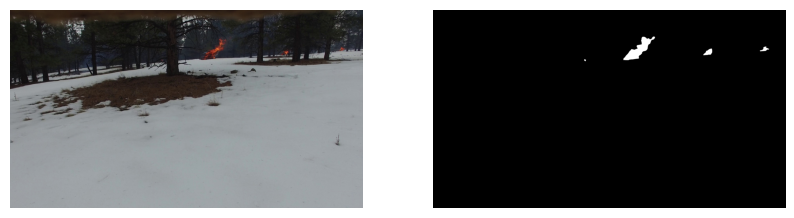

In [9]:
img, mask = dataset[0]
show(img, mask)

## Data Transforms

- see `SegformerImageProcessor.from_pretrained(checkpoint)`

```
SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}
```

In [10]:
class TransformedFlameSegDataset(FlameSegDataset):
    def __init__(self, image_dir, mask_dir):
        super().__init__(image_dir, mask_dir)

        self.preprocess = SegformerImageProcessor.from_pretrained(checkpoint)

    def __getitem__(self, idx):
        img, mask = super().__getitem__(idx)
        processed = self.preprocess(img, mask, return_tensors="pt")
        
        for k,v in processed.items():
            processed[k].squeeze_() # remove batch dimension
        
        return processed["pixel_values"].to(device), processed["labels"].to(device)

In [11]:
dataset = TransformedFlameSegDataset(IMAGE_DIR, MASK_DIR)

/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


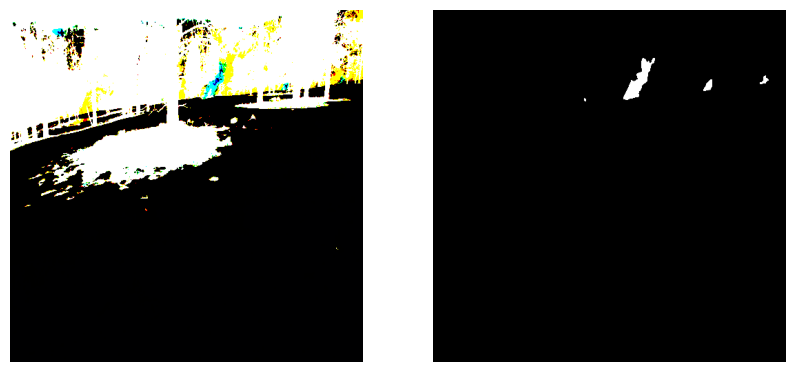

In [12]:
img, mask = dataset[0]
show(img, mask.unsqueeze(0))

# Dataloader

In [13]:
BATCH_SIZE = 16
TRAIN_FRAC = 0.8

train, test = random_split(dataset, [TRAIN_FRAC, 1-TRAIN_FRAC], torch.Generator().manual_seed(10))

train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
print("Train Size:", len(train))
print("Test Size:", len(test))

Train Size: 1603
Test Size: 400


# segformer-b2

In [15]:
class segformer_b2_FLAME(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = SegformerForSemanticSegmentation.from_pretrained(checkpoint, num_labels=2)
        self.post_processor = SegformerImageProcessor.from_pretrained(checkpoint).post_process_semantic_segmentation
        
    def forward(self, x, y):
        return self.model(x, y)
    
    def predict(self, x):
        out = self.model(x)
        batch_size = x.shape[0]
        size = x.shape[-2:]
        return torch.cat(self.post_processor(out, [size]*batch_size))

In [16]:
model = segformer_b2_FLAME().to(device)

Some weights of the model checkpoint at nvidia/mit-b2 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.pr

## Training

In [17]:
def train(model, dl, optim, epochs=2):
    train_loss = []

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        progress_bar = Progbar(len(dl))

        for i, (x, y) in enumerate(dl):

            out = model(x, y)
            loss = out["loss"]

            batch_loss.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

            progress_bar.update(i+1, [
                ("Epoch", epoch+1),
                ("Train Loss", loss.item()),
            ])

        epoch_loss = np.mean(np.array(batch_loss))
        train_loss.append(epoch_loss)

    return train_loss

In [18]:
lr = 1e-3
epochs = 3

optimizer = optim.Adam(model.parameters(), lr=lr)

In [19]:
hist = train(model, train_dl, optimizer, epochs=epochs)

101/101 [==============================] - 1539s 15s/step - Epoch: 3.0000 - Train Loss: 0.0042


## Checkpoint

In [20]:
PATH = "segformer_b2_FLAME.pt"

torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': hist[-1],
            }, PATH)

In [ ]:
!gdown --folder 1CW4XCA0CYBCpXWWjjsOXkARh_qTWIG5s
clear_output()

In [17]:
PATH = "./Checkpoints/segformer_b2_FLAME.pt"

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Evaluation

### Visualizing Output

In [21]:
model.eval()
img, mask = dataset[0]
out = model.predict(img.unsqueeze(dim=0))

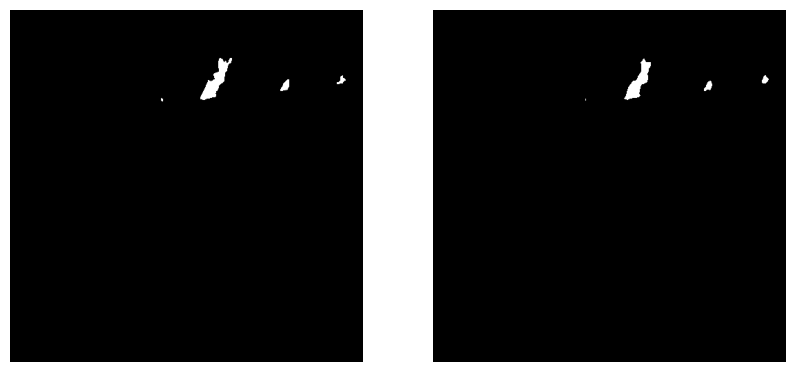

In [22]:
show(mask.unsqueeze(0), out.unsqueeze(0))

## Evaluation Functions

In [23]:
@torch.no_grad()
def evaluate(model, dl, metric_funcs={}):
    model.eval()
    metrics = {key: [] for key in metric_funcs}
    
    progress_bar = Progbar(len(dl))
    
    for i, (x, y) in enumerate(dl):
        pred = model.predict(x)
        for key, func in metric_funcs.items():
            pred = pred.view(-1).type(torch.uint8)
            y = y.view(-1).type(torch.uint8)

            value = func(pred, y).item()
            
            if type(value) not in [float, int]:
                raise Exception("Metric function must return a integer or a float")

            metrics[key].append(value)
        
        progress_bar.update(i+1, [(key, value[-1]) for key, value in metrics.items()])

    return {key: np.mean(np.array(value)) for key, value in metrics.items()}

In [24]:
f1 = BinaryF1Score().to(device)
iou = BinaryJaccardIndex().to(device)
metrics = evaluate(model, test_dl, {"F1": f1, "iou": iou})

25/25 [==============================] - 227s 9s/step - F1: 0.8680 - iou: 0.7671


## F1

In [25]:
print("F1", metrics["F1"])

F1 0.868038489818573


## IOU

In [26]:
print("IOU", metrics["iou"])

IOU 0.767059998512268
